In [2]:
from forse.networks.dcgan import *
import matplotlib.pyplot as plt
from forse.mmmtools import *

Using TensorFlow backend.


In [3]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/', img_size=(64, 64))

In [4]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
accs = np.load(dir_models+'acc_dreal_dfake_99999.npy')
dcgan.discriminator = load_model(dir_models+'discrim_99999.h5')
dcgan.generator = load_model(dir_models+'generat_99999.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


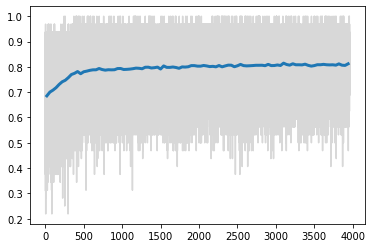

In [5]:
data = (accs[:,1]+accs[:,0])/2.
#data = (accs[:,1])
x_binned, data_binned = bin_history(data, bins=1000)
plt.plot(np.arange(len(data))/25., data, color='grey', alpha=0.3)
plt.plot(x_binned/25, data_binned, lw=3)

In [6]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_set2.npy'
X_train, X_test, Y_train, Y_test = dcgan.load_training_set(training_path+training_file)
gen_imgs_test = dcgan.generator.predict(X_test)
gen_imgs_train = dcgan.generator.predict(X_train)

Text(0.5, 1.0, 'HFI 5°')

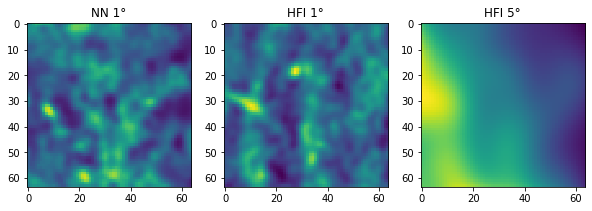

In [7]:
N = 234
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(gen_imgs_train[N, :, :, 0], vmin=-1, vmax=1)
plt.title('NN 1°')
plt.subplot(132)
plt.imshow(Y_train[N, :, :, 0])
plt.title('HFI 1°')
plt.subplot(133)
plt.imshow(X_train[N, :, :, 0])
plt.title('HFI 5°')


In [8]:
def normalize_patches(patches_file):
    Y,X = np.load(patches_file)
    Y = Y/X
    Y = np.transpose(Y[:len(Y)])
    X = np.transpose(X[:len(X)])
    X_edges = []
    Y_edges = []
    for i in range(Y.shape[-1]):
        X_edges.append([X[:,:,i].min(), X[:,:,i].max()])
        Y_edges.append([Y[:,:,i].min(), Y[:,:,i].max()])
        Y[:,:,i] = 2*(Y[:,:,i]-Y[:,:,i].min())/(Y[:,:,i].max()-Y[:,:,i].min())-1
        X[:,:,i] = 2*(X[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
    x_train, x_test = split_training_set(X)
    y_train, y_test = split_training_set(Y)
    X_edges = np.array(X_edges)
    Y_edges = np.array(Y_edges)
    return x_train, y_train, X_edges, Y_edges
def normalize_back(image, edges):
    nimage = (image+1)/2.*(edges[1]-edges[0])+edges[0]
    return(nimage)

In [9]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
Ys, Xs = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix64_set2.npy')
Yl, Xl = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix320_set2.npy')
Yl_zoom = np.zeros((1000, 64, 64))
X_edges = []
for i in range(40):
    Yl_zoom[i*25:(i+1)*25] = divide_image(Yl[i])
X = Yl_zoom
X = np.transpose(X[:1000])
for i in range(X.shape[-1]):
    X_edges.append([X[:,:,i].min(), X[:,:,i].max()])
    X[:,:,i] = 2*(X[:,:,i]-X[:,:,i].min())/(X[:,:,i].max()-X[:,:,i].min())-1
x_test, x_test2 = split_training_set(X)
X_edges = np.array(X_edges)    

In [10]:
gen_imgs_test = dcgan.generator.predict(x_test)

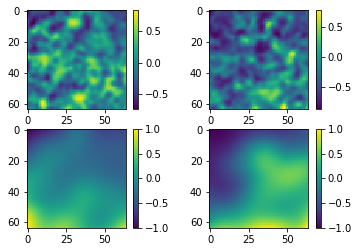

In [11]:
N=100
plt.subplot(221)
plt.imshow(gen_imgs_test[N, :, :, 0])
plt.colorbar()
plt.subplot(222)
plt.imshow(gen_imgs_test[N+1, :, :, 0])
plt.colorbar()
plt.subplot(223)
plt.imshow(x_test[N, :, :, 0])
plt.colorbar()
plt.subplot(224)
plt.imshow(x_test[N+1, :, :, 0])
plt.colorbar()

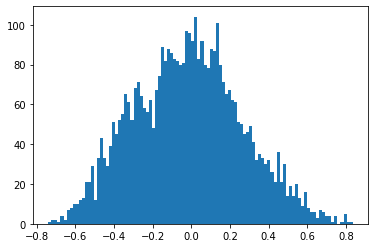

In [12]:
hist=plt.hist(gen_imgs_test[N, :, :, 0].flatten(), bins=100)

In [13]:
pysm_ss, pysm_1d = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR12amin_LR1deg_Npix320_set2.npy')
pysm_ss_zoom = np.zeros((1000, 64, 64))
pysm_1d_zoom = np.zeros((1000, 64, 64))
pysm_ss_edges = []
for i in range(40):
    pysm_ss_zoom[i*25:(i+1)*25] = divide_image(pysm_ss[i])
    pysm_1d_zoom[i*25:(i+1)*25] = divide_image(pysm_1d[i])
for i in range(1000):
    ratio = pysm_ss_zoom/pysm_1d_zoom
    pysm_ss_edges.append([ratio[i].min(), ratio[i].max()])
pysm_ss_edges = np.array(pysm_ss_edges)

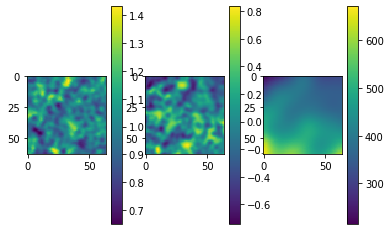

In [14]:
pysm_only_ss = pysm_ss_zoom/pysm_1d_zoom
plt.subplot(131)
plt.imshow(pysm_only_ss[N])
plt.colorbar()
plt.subplot(132)
plt.imshow(gen_imgs_test[N, :, :, 0])
plt.colorbar()
plt.subplot(133)
plt.imshow(pysm_1d_zoom[N])
plt.colorbar()

In [15]:
NN_norm_back = normalize_back(gen_imgs_test[N, :, :, 0], pysm_ss_edges[N])

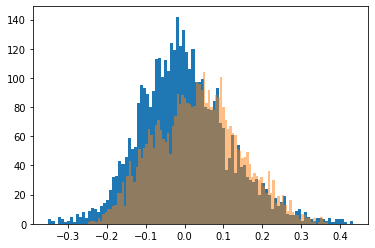

In [16]:
hist = plt.hist((pysm_only_ss[N]-1).flatten(), bins=100)
hist = plt.hist((NN_norm_back-1).flatten(), bins=100, alpha=0.5)

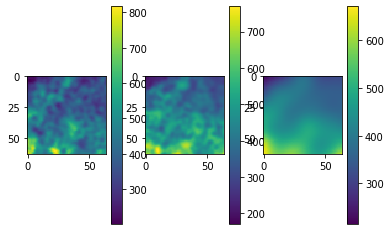

In [17]:
plt.subplot(131)
plt.imshow(pysm_ss_zoom[N])
plt.colorbar()
plt.subplot(132)
plt.imshow(NN_norm_back*pysm_1d_zoom[N])
plt.colorbar()
plt.subplot(133)
plt.imshow(pysm_1d_zoom[N])
plt.colorbar()

In [18]:
bnormed_gen2 = np.copy(gen_imgs_test)
bnormed_gen = np.copy(gen_imgs_test)
for i in range(800):
    bnormed_gen2[i] = (normalize_back(gen_imgs_test[i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))
    bnormed_gen[i] = (normalize_back(gen_imgs_test[i], pysm_ss_edges[i]))

In [19]:
a = 250
b = a+25
small_scale = unify_image(bnormed_gen2[a:b])
large_scale = pysm_1d[int(a/25)]

Text(0.5, 1.0, 'PySM Large scales (1 deg)')

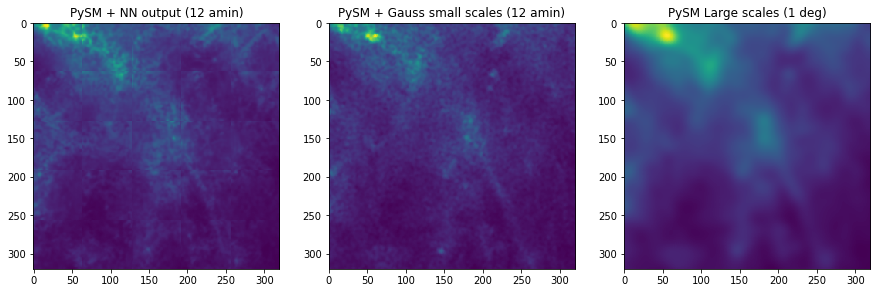

In [20]:
plt.figure(figsize=(15, 8))
#plt.subplot(131)
#plt.imshow(small_scale)
plt.subplot(131)
plt.imshow(small_scale*large_scale)
plt.title('PySM + NN output (12 amin)')
plt.subplot(132)
plt.imshow(pysm_ss[int(a/25)])
plt.title('PySM + Gauss small scales (12 amin)')
plt.subplot(133)
plt.imshow(large_scale)
plt.title('PySM Large scales (1 deg)')

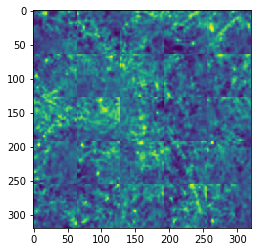

In [21]:
plt.imshow(small_scale)

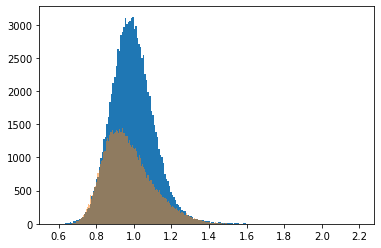

In [22]:
only_ss = pysm_ss[int(a/25)]/large_scale
hist = plt.hist(only_ss.flatten(), bins=200)
hist = plt.hist(small_scale.flatten(), bins=200, alpha=0.5)

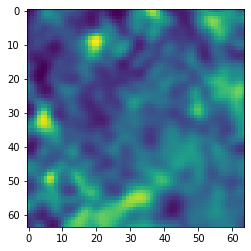

In [23]:
plt.imshow(bnormed_gen[a+5, :, :, 0])

# test oversampling mean

In [24]:
from math import ceil

def forward ( image, step, side ) :
    """
    Parameters
    ----------
    image : array-like object shape = ( npix, npix )
    step : lenght to move in decomposition
    side : side lenght of output images
    
    Returns
    -------
    image array, pixel weight, limiting indexes of images in array
    """
    
    # preliminaries and exceptions
    xnpix, ynpix = image.shape
    if ( xnpix == ynpix ) :
        imgside = xnpix
    else :
        raise ValueError( "Function forward only works for square images." )

    if ( step <= side ) :
        pass
    else :
        raise ValueError( "'side' should be greater than or equal to 'step'." )

    if ( side <= imgside ) :
        pass
    else :
        raise ValueError( "'side' should be strictly smaller than the original image side lenght." )
    
    if ( 1 <= step ) or ( step <= imgside ) :
        pass
    else :
        raise ValueError( "Step lenght selected not valid ( should be '1 <= step <= imgside' )" )
    
    # create array of ranges for slicing
    img_index = np.array( [ [ idx, min( idx + side, ynpix ) ]
                        for idx in range( 0, imgside, step ) ] )
    sider = np.array( [ np.arange( idx[ 0 ], idx[ 1 ] ) for idx in img_index ] )
    
    # create output array of images
    NN = ceil( imgside / step )
    img_array = np.zeros( shape = ( NN * NN, side, side ) )
    img_weights = np.zeros( shape = image.shape )
    
    for ii in range( 0, NN ) :
        for jj in range( 0, NN ) :
            img_array[ ii * NN + jj,
                       :img_index[ ii, 1 ] - img_index[ ii, 0 ], 
                       :img_index[ jj, 1 ] - img_index[ jj, 0 ] ] += image[ np.ix_( sider[ ii ], 
                                                                                    sider[ jj ] ) ]
            img_weights[ np.ix_( sider[ ii ], sider[ jj ] ) ] += 1

    return img_array, img_weights, img_index


# ===================================================================================================


def backward ( image_array, image_weights, indexes ) :
    """
    Parameters
    ----------
    image_array : ordered array of images
    image_weights : pixel weight
    indexes : limiting indexes of images in array
    
    Returns
    -------
    recomposed image, averaged on overlapping pixels
    """

    # create output image
    out_img = np.zeros( shape = image_weights.shape )

    # get number of tiles
    NN = len( indexes )

    # put the image back together by looping over image array
    for ii in range( NN ) :
        imin = max( 0, indexes[ ii, 0 ] )
        imax = min( out_img.shape[ 0 ], indexes[ ii, 1 ] )
        for jj in range( NN ) :
            jmin = max( 0, indexes[ jj, 0 ] )
            jmax = min( out_img.shape[ 1 ], indexes[ jj, 1 ] )

            out_img[ imin:imax, jmin:jmax ] += image_array[ ii * NN + jj, :imax-imin, :jmax-jmin ]

    return out_img / image_weights

In [26]:
test_oversamp = forward(large_scale, 54, 64)
test_oversamp = np.array(test_oversamp)
Xos = test_oversamp[0]
for i in range(Xos.shape[0]):
    Xos[i] = 2*(Xos[i]-Xos[i].min())/(Xos[i].max()-Xos[i].min())-1
Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
gen_imgs_os = dcgan.generator.predict(Xos)
temp = gen_imgs_os[:, :, :, 0]
print(temp.shape)
out_oversamp = np.copy(test_oversamp)
out_oversamp[0] = temp

(36, 64, 64)


In [25]:
pippo = backward(out_oversamp[0], out_oversamp[1], out_oversamp[2])
pippo_back = (normalize_back(pippo, [np.min(pysm_ss_edges[:,0]), np.max(pysm_ss_edges[:,1])]))
pippo_back =  pippo_back/np.std(pippo_back)*np.std(only_ss)

Text(0.5, 1.0, 'PySM Large scales (1 deg)')

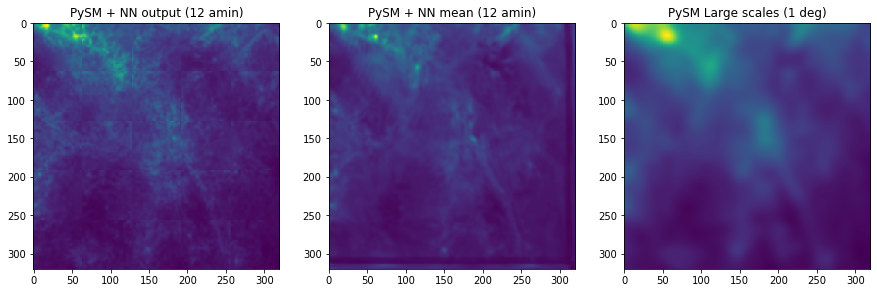

In [26]:
plt.figure(figsize=(15, 8))
#plt.subplot(131)
#plt.imshow(small_scale)
plt.subplot(131)
plt.imshow(small_scale*large_scale)
plt.title('PySM + NN output (12 amin)')
plt.subplot(132)
plt.imshow(pippo_back*large_scale)
plt.title('PySM + NN mean (12 amin)')
plt.subplot(133)
plt.imshow(pysm_1d[int(a/25)])
plt.title('PySM Large scales (1 deg)')

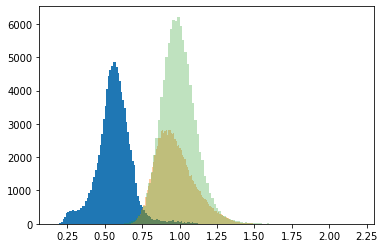

In [28]:
hist = plt.hist(pippo_back.flatten(), bins=100)
hist = plt.hist(small_scale.flatten(), bins=100, alpha=0.4)
hist = plt.hist(only_ss.flatten(), bins=100, alpha=0.3)

0.1155899104713758
0.11558991047137579


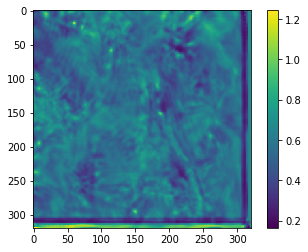

In [29]:
plt.imshow(pippo_back)
plt.colorbar()
print(np.std(pippo_back))
print(np.std(only_ss))

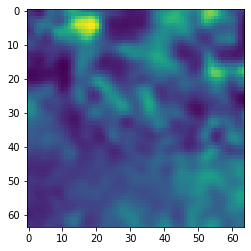

In [30]:
plt.imshow(small_scale[0:64, 0:64])

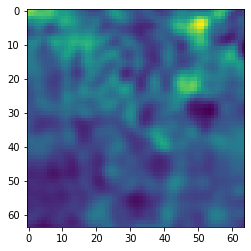

In [31]:
plt.imshow(small_scale[64:128, 64:128])

In [32]:
def calculate_2d_spectrum(Map1,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    #FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap1))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

In [33]:
binned_ell, binned_spectrumLS = calculate_2d_spectrum(pysm_1d[int(a/25)],10,1024,3.75,320)
binned_ell, binned_spectrumSS = calculate_2d_spectrum(pysm_ss[int(a/25)],10,1024,3.75,320)
binned_ell, binned_spectrumNN = calculate_2d_spectrum(small_scale*large_scale,10,1024,3.75,320)
binned_ell, pippo_spec = calculate_2d_spectrum(pippo_back*large_scale,10,1024,3.75,320)

/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/numpy-1.16.2-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/k/krach/usr/python_prefix/lib/python3.6/site-packages/numpy-1.16.2-py3.6-linux-x86_64.egg/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


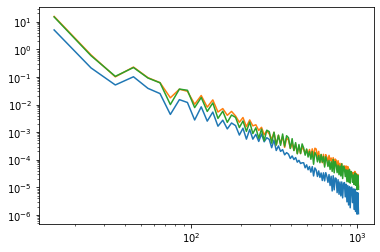

In [34]:
plt.loglog(binned_ell, pippo_spec)
plt.loglog(binned_ell, binned_spectrumSS)
plt.loglog(binned_ell, binned_spectrumNN)

# test minimization problem

In [442]:
tmin = np.copy(gen_imgs_test[a:b])

In [443]:
tmin_unif = small_scale = unify_image(tmin)

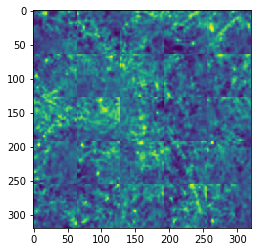

In [444]:
plt.imshow(tmin_unif)

In [596]:
t0 = tmin[6, :, :, 0]
print(t0.shape)

(64, 64)


In [597]:
t1 = tmin[7, :, :, 0]

In [598]:
t01 = np.concatenate((t0, t1), axis=1)

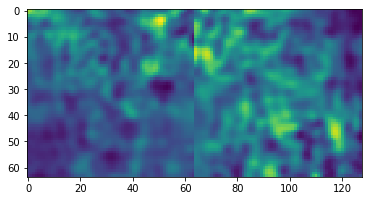

In [599]:
plt.imshow(t01)

In [600]:
def find_min_max(args):
    vmin = args[0]
    vmax = args[1]
    v0 = t0[:, 63]
    v1 = t1[:, 0]
    v1_norm = (v1+1)/2.*(vmax-vmin)+vmin
    diff = np.sum((np.array(v0-v1_norm)**2))
    return diff

In [601]:
from scipy.optimize import minimize

In [588]:
min_fit = minimize(find_min_max, x0=[0, 0], method='Nelder-Mead')

In [589]:
min_fit

 final_simplex: (array([[-0.29244102, -0.2484401 ],
       [-0.29251282, -0.24838222],
       [-0.2924728 , -0.24844169]]), array([1.9187634, 1.9187634, 1.9187634]))
           fun: 1.9187633991241455
       message: 'Optimization terminated successfully.'
          nfev: 117
           nit: 59
        status: 0
       success: True
             x: array([-0.29244102, -0.2484401 ])

In [590]:
v0 = t0[:, 63]
v1 = t1[:, 0]
diff = np.sum(np.array(v0-v1)**2.)
print(diff)

12.922218


In [591]:
def normalize_back(image, edges):
    nimage = (image+1)/2.*(edges[1]-edges[0])+edges[0]
    return(nimage)

In [592]:
new_t1 = normalize_back(t1, [min_fit.x[0], min_fit.x[1]])

In [593]:
diff = np.sum(np.array(v0-new_t1[0, :])**2.)
print(diff)

1.8833015


In [594]:
pippo = np.concatenate((t0, new_t1), axis=1)

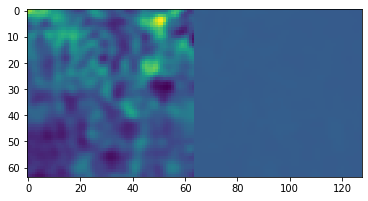

In [595]:
plt.imshow(pippo)

# Test larger input

In [160]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/', img_size=(320, 320))

In [161]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
accs = np.load(dir_models+'acc_dreal_dfake_99999.npy')
dcgan.discriminator = load_model(dir_models+'discrim_99999.h5')
dcgan.generator = load_model(dir_models+'generat_99999.h5')

In [162]:
dcgan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 1)         2054401   
Total params: 2,054,401
Trainable params: 2,053,121
Non-trainable params: 1,280
_________________________________________________________________


In [164]:
wor = dcgan.generator.get_weights()

In [165]:
dcgan.generator.layers.pop(0)
dcgan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 1)         2054401   
Total params: 2,054,401
Trainable params: 2,053,121
Non-trainable params: 1,280
_________________________________________________________________


In [166]:
newInput = Input(shape=(320,320,1))    # let us say this new InputLayer
newOutputs = dcgan.generator(newInput)
newModel = Model(newInput, newOutputs)

In [167]:
newModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 320, 320, 1)       0         
_________________________________________________________________
model_2 (Model)              multiple                  2054401   
Total params: 2,054,401
Trainable params: 2,053,121
Non-trainable params: 1,280
_________________________________________________________________


In [171]:
wnew= newModel.get_weights()

In [174]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix320_set2.npy'
X_train, X_test, Y_train, Y_test = dcgan.load_training_set(training_path+training_file)
gen_imgs_test = newModel.predict(X_test)

In [175]:
gen_imgs_test.shape

(200, 320, 320, 1)

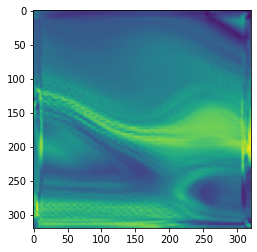

In [177]:
plt.imshow(gen_imgs_test[0, :, :, 0])

# test filters

In [358]:
p=32
test_oversamp = forward(large_scale, 64-p, 64)
test_oversamp = np.array(test_oversamp)
Xos = test_oversamp[0]
for i in range(Xos.shape[0]):
    Xos[i] = 2*(Xos[i]-Xos[i].min())/(Xos[i].max()-Xos[i].min())-1
Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
gen_imgs_os = dcgan.generator.predict(Xos)
temp = gen_imgs_os[:, :, :, 0]
print(temp.shape)
out_oversamp = np.copy(test_oversamp)
out_oversamp[0] = temp

(100, 64, 64)


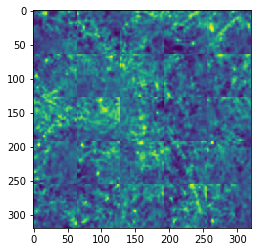

In [359]:
plt.imshow(small_scale)

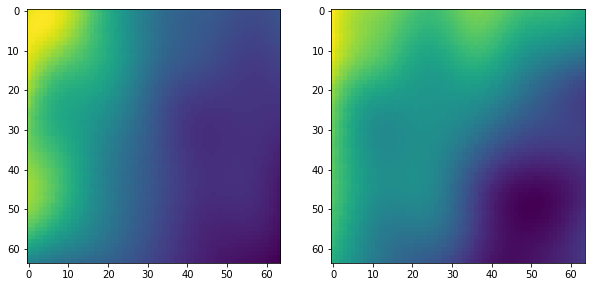

In [431]:
k = 60
k2 = 61
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(Xos[k, :, :, 0])
plt.subplot(122)
plt.imshow(Xos[k2, :, :, 0])

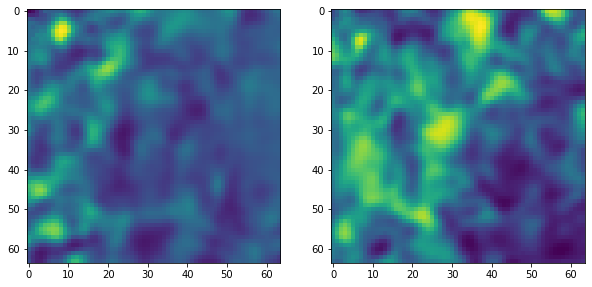

In [432]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(temp[k])
plt.subplot(122)
plt.imshow(temp[k2])

In [433]:
def low_pass_filter(npix_tot, npix1, npix2=None):
    if not npix2:
        npix2 = npix_tot
    pix = np.arange(npix_tot)
    filt = 0.5*(1-np.cos(np.pi*(npix2-pix)/(npix2-npix1)))
    filt[0:npix1] = 1.
    return np.array([filt])
def high_pass_filter(npix_tot, npix2, npix1=None):
    if not npix1:
        npix1 = 0
    pix = np.arange(npix_tot)
    filt = 0.5*(1-np.cos(np.pi*(pix-npix1)/(npix2-npix1)))
    filt[npix2:npix_tot] = 1.
    return np.array([filt])

In [434]:
lpf = low_pass_filter(64, 64-p)
hpf = high_pass_filter(64, p)

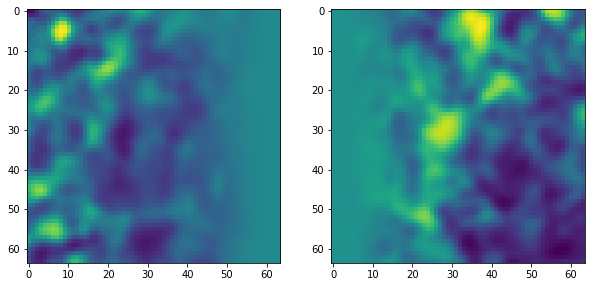

In [435]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(temp[k]*lpf)
plt.subplot(122)
plt.imshow(temp[k2]*hpf)

In [436]:
new_img = np.zeros((64, 64*2-p))

In [437]:
temp0filt = temp[k]*lpf
temp1filt = temp[k2]*hpf
new_img[:, 0:64] = temp0filt
new_img[:, 64-p:] = new_img[:, 64-p:] + temp1filt

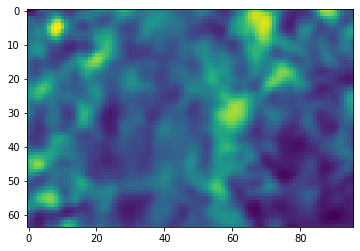

In [438]:
plt.imshow(new_img)

In [270]:
256-5*49

11

In [288]:
64+(64-16)*5

304